# GLM: Model Selection


**A fairly minimal reproducable example of Model Selection using WAIC, and LOO as currently implemented in `pymc3.stats`.**

+ This example creates two toy datasets under linear and quadratic models, and then tests the fit of a range of polynomial linear models upon those datasets by using Widely Applicable Information Criterion (WAIC, available as `stats.waic`), and leave-one-out (LOO, available as `stats.loo`) cross-validation using Pareto-smoothed importance sampling (PSIS).
+ The example was inspired by Jake Vanderplas' [blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, although in this first iteration, Cross-Validation and Bayes Factor comparison are not implemented.
+ The datasets are tiny and generated within this Notebook. They contain errors in the measured value (y) only.


For more information on Model Selection in PyMC3, and about Bayesian model selection, you could start with:

+ Thomas Wiecki's [detailed response](https://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3/166383#166383) to a question on Cross Validated
+ The Deviance Information Criterion: 12 Years On [(Speigelhalter et al 2014)](http://onlinelibrary.wiley.com/doi/10.1111/rssb.12062/abstract)
+ Bayesian predictive information criterion for the evaluation of hierarchical Bayesian and empirical Bayes models [(Ando 2007)](https://doi.org/10.1093/biomet/asm017)
+ A Widely Applicable Bayesian Information Criterion [(Watanabe 2013)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf)
+ Efficient Implementation of Leave-One-Out Cross-Validation and WAIC for Evaluating Fitted Bayesian Models [(Vehtari et al 2015)](http://arxiv.org/abs/1507.04544)



**Contents**

+ [Setup](#Setup)  
+ [Generate Toy Datasets](#Generate-Toy-Datasets)  
+ [Demonstrate Simple Linear Model](#Demonstrate-Simple-Linear-Model)
+ [Create Higher-Order Linear Models](#Create-Higher-Order-Linear-Models)
+ [Compare Watanabe-Akaike Information Criterion (WAIC)](#Compare-Watanabe---Akaike-Information-Criterion-[WAIC])
+ [Compare leave-one-out Cross-Validation (LOO)](#Compare-leave-one-out-Cross-Validation-[LOO])

## Setup

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate

import pymc3 as pm
import theano as thno
import theano.tensor as T 

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

### Local Functions

In [3]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    ''' 
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's returned in e dataframe for interest only.
    '''
    
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
                
    ## create linear or quadratic model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
    df['outlier'] = rndst.binomial(1,p,n)
    
    ## add noise, with extreme noise for marked outliers
    df['y'] += ((1-df['outlier']) * df['latent_error'])
    df['y'] += (df['outlier'] * df['outlier_error'])
   
    ## round
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)
       
    ## add label
    df['source'] = 'linear' if c == 0 else 'quadratic'
    
    ## create simple linspace for plotting true model
    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2
    dfp = pd.DataFrame({'x':plotx, 'y':ploty})
    
    return df, dfp
    

def interact_dataset(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    ''' 
    Convenience function:
    Interactively generate dataset and plot
    '''
    
    df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)
        

def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
    '''
    Convenience function:
    Plot the two generated datasets in facets with generative model
    '''
    
    df = pd.concat((df_lin, df_quad), axis=0)
    dfp_lin, dfp_quad
   
    g = sns.FacetGrid(col='source', hue='source', data=df, size=6
                      ,sharey=False, legend_out=False)

    _ = g.map(plt.scatter, 'x', 'y', alpha=0.7, s=100, lw=2, edgecolor='w')

    _ = g.axes[0][0].plot(dfp_lin['x'], dfp_lin['y'], '--', alpha=0.6)
    _ = g.axes[0][1].plot(dfp_quad['x'], dfp_quad['y'], '--', alpha=0.6)
                
        
def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''
    
    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
    
    
def create_poly_modelspec(k=1):
    ''' 
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()


def run_models(df, upper_order=5):
    ''' 
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity. 
    Suggest limit to max order 5 since calculation time is exponential.
    '''
    
    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Normal())

            # For speed, we're using Metropolis here
            traces[nm] = pm.sample(5000, pm.Metropolis())[1000::5]
            
    return models, traces


def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    '''
    
    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)

## Generate Toy Datasets

### Interactively Draft Data

Throughout the rest of the Notebook, we'll use two toy datasets created by a linear and a quadratic model respectively, so that we can better evaluate the fit of the model selection.

Right now, lets use an interactive session to play around with the data generation function in this Notebook, and get a feel for the possibilities of data we could generate.


$$y_{i} = a + bx_{i} + cx_{i}^{2} + \epsilon_{i}$$

where:  
$i \in n$ datapoints
$\epsilon \sim \mathcal{N}(0,latent\_sigma\_y)$


**NOTE on outliers:** 

+ We can use value `p` to set the (approximate) proportion of 'outliers' under a bernoulli distribution.
+ These outliers have a 10x larger `latent_sigma_y`
+ These outliers are labelled in the returned datasets and may be useful for other modelling, see another example Notebook `GLM-robust-with-outlier-detection.ipynb`

In [4]:
interactive(interact_dataset, n=[5,50,5], p=[0,.5,.05], a=[-50,50]
            ,b=[-10,10], c=[-3,3], latent_sigma_y=[0,1000,50])

A Jupyter Widget

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

### Create Datasets for Modelling

We can use the above interactive plot to get a feel for the effect of the params. Now we'll create 2 fixed datasets to use for the remainder of the Notebook. 

1. For a start, we'll create a linear model with small noise. Keep it simple.
2. Secondly, a quadratic model with small noise

In [5]:
n = 12
df_lin, dfp_lin = generate_data(n=n, p=0, a=-30, b=5, c=0, latent_sigma_y=40)
df_quad, dfp_quad = generate_data(n=n, p=0, a=-200, b=2, c=3, latent_sigma_y=500)

##### Scatterplot against model line

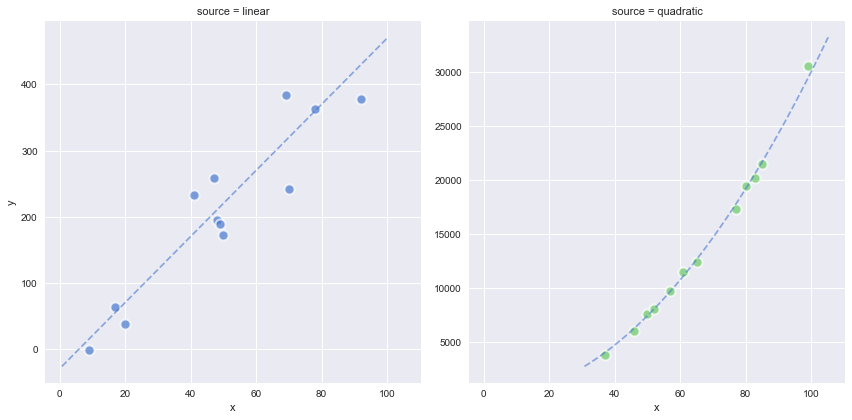

In [6]:
plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad)

**Observe:**

+ We now have two datasets `df_lin` and `df_quad` created by a linear model and quadratic model respectively.
+ You can see this raw data, the ideal model fit and the effect of the latent noise in the scatterplots above
+ In the folowing plots in this Notebook, the linear-generated data will be shown in Blue and the quadratic in Green.


### Standardize

In [7]:
dfs_lin = df_lin.copy()
dfs_lin['x'] = (df_lin['x'] - df_lin['x'].mean()) / df_lin['x'].std()

dfs_quad = df_quad.copy()
dfs_quad['x'] = (df_quad['x'] - df_quad['x'].mean()) / df_quad['x'].std()

##### Create ranges for later ylim xim

In [8]:
dfs_lin_xlims = (dfs_lin['x'].min() - np.ptp(dfs_lin['x'])/10,
                 dfs_lin['x'].max() + np.ptp(dfs_lin['x'])/10)

dfs_lin_ylims = (dfs_lin['y'].min() - np.ptp(dfs_lin['y'])/10,
                 dfs_lin['y'].max() + np.ptp(dfs_lin['y'])/10)

dfs_quad_ylims = (dfs_quad['y'].min() - np.ptp(dfs_quad['y'])/10,
                  dfs_quad['y'].max() + np.ptp(dfs_quad['y'])/10)

## Demonstrate Simple Linear Model

This *linear model* is really simple and conventional, an OLS with L2 constraints (Ridge Regression):

$$y = a + bx + \epsilon$$


### Define model using ordinary pymc3 method

In [9]:
with pm.Model() as mdl_ols:  
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## define Linear model
    yest = b0 + b1 * df_lin['x']

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    sigma_y = pm.HalfCauchy('sigma_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df_lin['y'])

    traces_ols = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, b1, b0]
100%|██████████| 2500/2500 [00:07<00:00, 330.07it/s]


##### View Traces after burn-in

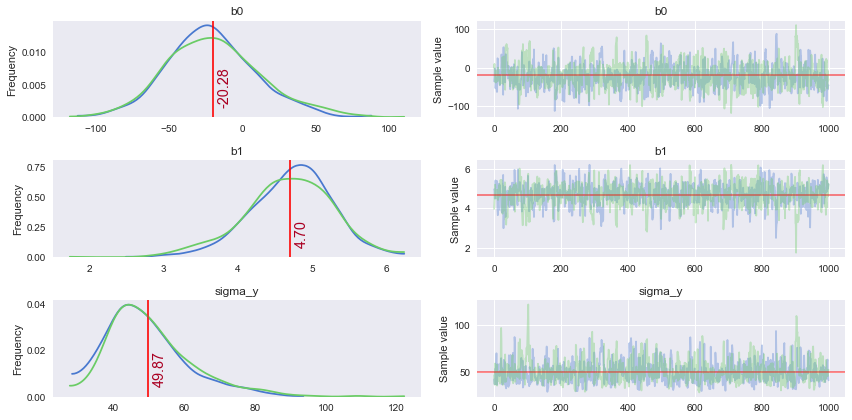

In [10]:
plot_traces(traces_ols, retain=1000)

**Observe:**

+ This simple OLS manages to make fairly good guesses on the model parameters - the data has been generated fairly simply after all - but it does appear to have been fooled slightly by the inherent noise.


### Define model using pymc3 GLM method

PyMC3 has a quite recently developed method - `glm` - for defining models using a `patsy`-style formula syntax. This seems really useful, especially for defining simple regression models in fewer lines of code. 

I couldn't find a direct comparison in the the examples, so before I launch into using `glm` for the rest of the Notebook, here's the same OLS model as above, defined using `glm`.

In [11]:
with pm.Model() as mdl_ols_glm:
    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.GLM.from_formula('y ~ 1 + x', df_lin, family=pm.glm.families.Normal())
    
    traces_ols_glm = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 2500/2500 [00:07<00:00, 335.07it/s]


##### View Traces after burn-in

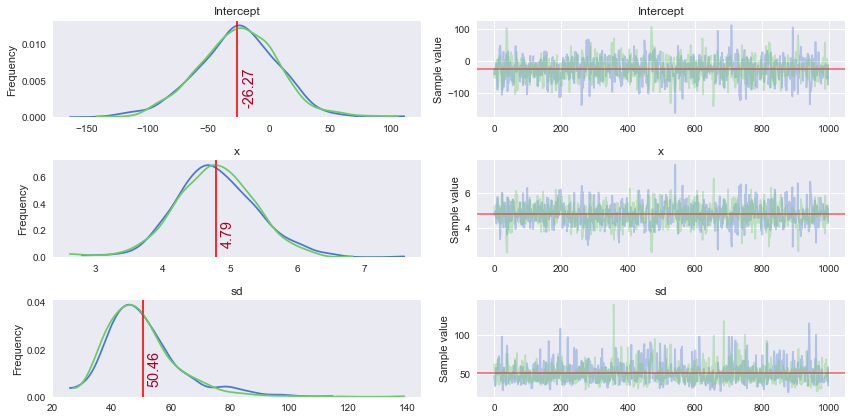

In [12]:
plot_traces(traces_ols_glm, retain=1000)

**Observe:**

+ The output parameters are of course named differently to the custom naming before. Now we have:

    `b0 == Intercept`  
    `b1 == x`  
    `sigma_y_log == sd_log`  
    `sigma_y == sd`  
    
    
+ However, naming aside, this `glm`-defined model appears to behave in a very similar way, and finds the same parameter values as the conventionally-defined model - any differences are due to the random nature of the sampling.
+ We can quite happily use the `glm` syntax for further models below, since it allows us to create a small model factory very easily.

---

---

## Create Higher-Order Linear Models

Back to the real purpose of this Notebook: demonstrate model selection.

First, let's create and run a set of polynomial models on each of our toy datasets. By default this is for models of order 1 to 5.

### Create and run polynomial models

Please see `run_models()` above for details. Generally, we're creating 5 polynomial models and fitting each to the chosen dataset

In [13]:
models_lin, traces_lin = run_models(dfs_lin, 5)


Running: k1


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:06<00:00, 866.56it/s] 



Running: k2


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:12<00:00, 443.34it/s]



Running: k3


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:17<00:00, 316.01it/s]



Running: k4


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 4)]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:25<00:00, 212.88it/s]



Running: k5


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 5)]
>Metropolis: [np.power(x, 4)]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:37<00:00, 147.69it/s]


In [14]:
models_quad, traces_quad = run_models(dfs_quad, 5)


Running: k1


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:07<00:00, 761.36it/s]



Running: k2


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:11<00:00, 466.46it/s]



Running: k3


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:19<00:00, 284.74it/s]



Running: k4


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 4)]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:25<00:00, 217.11it/s]



Running: k5


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd_log__]
>Metropolis: [np.power(x, 5)]
>Metropolis: [np.power(x, 4)]
>Metropolis: [np.power(x, 3)]
>Metropolis: [np.power(x, 2)]
>Metropolis: [x]
>Metropolis: [Intercept]
100%|██████████| 5500/5500 [00:38<00:00, 142.25it/s]


## A really bad method for model selection: compare likelihoods

##### Evaluate log likelihoods straight from model.logp

In [15]:
dfll = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfll.index.name = 'model'

for nm in dfll.index:
    dfll.loc[nm,'lin'] = - models_lin[nm].logp(pm.summary(traces_lin[nm],
                                                          traces_lin[nm].varnames)['mean'].to_dict())
    
    dfll.loc[nm,'quad'] = - models_quad[nm].logp(pm.summary(traces_quad[nm],
                                                            traces_quad[nm].varnames)['mean'].to_dict())

dfll = pd.melt(dfll.reset_index(), id_vars=['model'],
               var_name='poly', value_name='log_likelihood')

##### Plot log-likelihoods

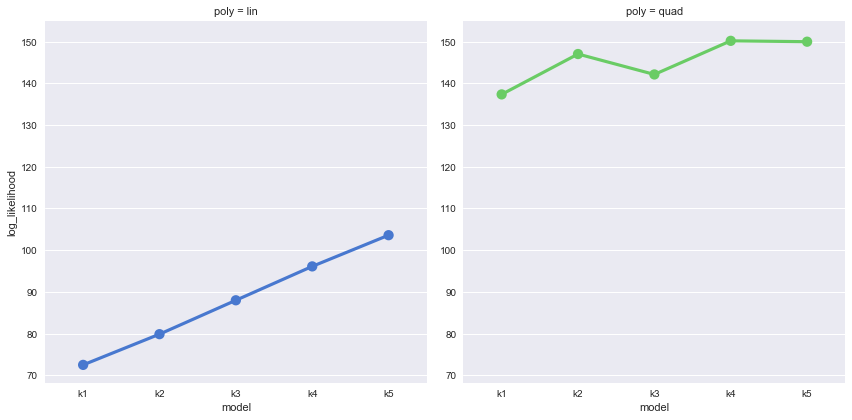

In [16]:
g = sns.factorplot(x='model', y='log_likelihood', col='poly',
                   hue='poly', data=dfll, size=6)

**Observe:**

+ Again we're showing the linear-generated data at left (Blue) and the quadratic-generated data on the right (Green)
+ For both datasets, as the models get more complex, the likelhood increases monotonically
+ This is expected, since the models are more flexible and thus able to (over)fit more easily.
+ This overfitting makes it a terrible idea to simply use the likelihood to evaluate the model fits.

### View posterior predictive fit

Just for the linear, generated data, lets take an interactive look at the posterior predictive fit for the models k1 through k5.

As indicated by the likelhood plots above, the higher-order polynomial models exhibit some quite wild swings in the function in order to (over)fit the data

In [17]:
interactive(plot_posterior_cr, models=fixed(models_lin), traces=fixed(traces_lin)
            ,rawdata=fixed(dfs_lin), xlims=fixed(dfs_lin_xlims), datamodelnm=fixed('linear')
            ,modelnm = ['k1','k2','k3','k4','k5'])

A Jupyter Widget

## Compare Watanabe - Akaike Information Criterion [WAIC]

The Widely Applicable Information Criterion (WAIC) can be used to calculate the goodness-of-fit of a model using numerical techniques. See [(Watanabe 2013)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) for details.

In [18]:
pm.stats.waic(model=models_lin['k1'], trace=traces_lin['k1'])

WAIC_r(WAIC=130.70556566366588, WAIC_se=3.7870123962266851, p_WAIC=2.212835033195899)

**Observe:**

+ We get three different measurements: 
    - waic: widely available information criterion
    - waic_se: standard error of waic
    - p_waic: effective number parameters
    
In this case we are interested in the WAIC score, we can plot also the standard error of the estimation, which is nice.

##### Now loop through all the models and calculate the WAIC

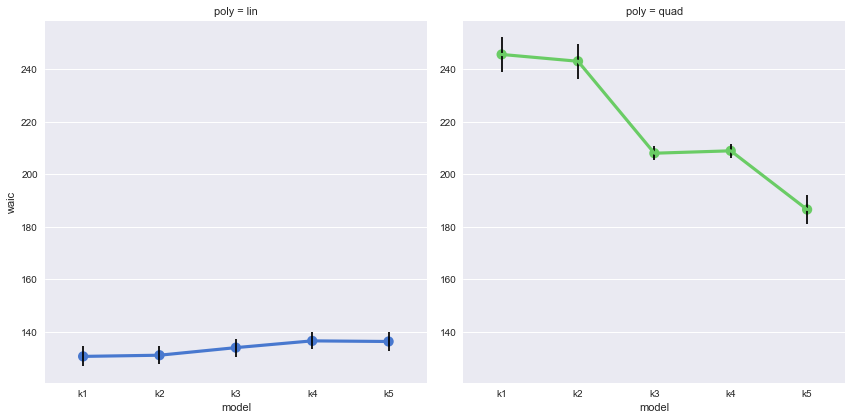

In [19]:
dfwaic = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfwaic.index.name = 'model'

for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.stats.waic(traces_lin[nm], models_lin[nm])[:2]
    dfwaic.loc[nm, 'quad'] = pm.stats.waic(traces_quad[nm], models_quad[nm])[:2]
dfwaic = pd.melt(dfwaic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic_')
dfwaic[['waic', 'waic_se']] = dfwaic['waic_'].apply(pd.Series)

# Define a wrapper function for plt.errorbar
def errorbar(x, y, se, order, color, **kws):
    xnum = [order.index(x_i) for x_i in x]
    plt.errorbar(xnum, y, yerr=se, color='k', ls='None')
    
g = sns.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfwaic, size=6)
order = sns.utils.categorical_order(dfwaic['model'])
g.map(errorbar,'model', 'waic', 'waic_se', order=order);

**Observe**

+ We should prefer the model(s) with lower WAIC


+ Linear-generated data (lhs):
    + The WAIC seems quite flat across models
    + The WAIC seems best (lowest) for simpler models.


+ Quadratic-generated data (rhs):
    + The WAIC is also quite flat across the models
    + The lowest WAIC is model **k4**, but **k3** - **k5** are more or less the same. 
    

## Compare leave-one-out Cross-Validation [LOO]

Leave-One-Out Cross-Validation or K-fold Cross-Validation is another quite universal approach for model selection. However, to implement K-fold cross-validation we need to paritition the data repeatly and fit the model on every partition. It can be very time consumming (computation time increase roughly as a factor of K). Here we are applying the numerical approach using the posterier trace as suggested in Vehtari et al 2015.

In [20]:
pm.stats.loo(model=models_lin['k1'], trace=traces_lin['k1'])

LOO_r(LOO=130.93539388009688, LOO_se=3.8533965515796376, p_LOO=2.3277491414113882)

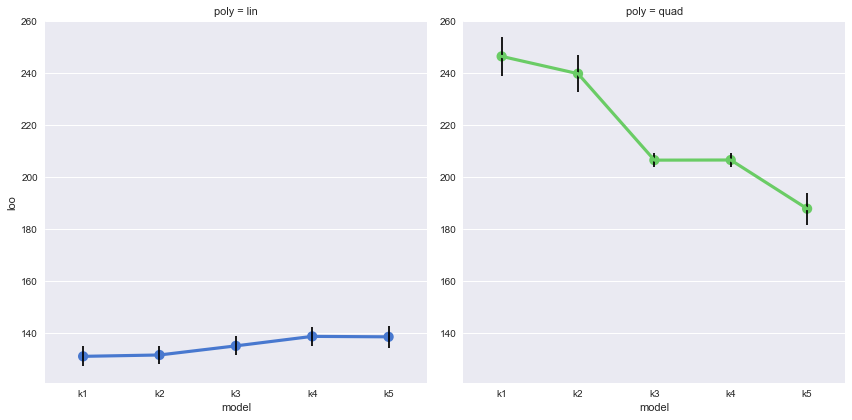

In [21]:
dfloo = pd.DataFrame(index=['k1','k2','k3','k4','k5'], columns=['lin','quad'])
dfloo.index.name = 'model'

for nm in dfloo.index:
    dfloo.loc[nm, 'lin'] = pm.stats.loo(traces_lin[nm], models_lin[nm])[:2]
    dfloo.loc[nm, 'quad'] = pm.stats.loo(traces_quad[nm], models_quad[nm])[:2]
dfloo = pd.melt(dfloo.reset_index(), id_vars=['model'], var_name='poly', value_name='loo_')
dfloo[['loo', 'loo_se']] = dfloo['loo_'].apply(pd.Series)
    
g = sns.factorplot(x='model', y='loo', col='poly', hue='poly', data=dfloo, size=6)
order = sns.utils.categorical_order(dfloo['model'])
g.map(errorbar,'model', 'loo', 'loo_se', order=order);

**Observe**

+ We should prefer the model(s) with lower LOO. You can see that LOO is nearly identical with WAIC. That's because WAIC is asymptotically equal to LOO. However, PSIS-LOO is supposedly more robust than WAIC in the finite case (under weak priors or influential observation). 


+ Linear-generated data (lhs):
    + The LOO is also quite flat across models
    + The LOO is also seems best (lowest) for simpler models.


+ Quadratic-generated data (rhs):
    + The same pattern as the WAIC
    

## Final remarks and tips

It is important to keep in mind that, with more data points, the real underlying model (one that we used to generate the data) should outperforms other models. 

In general, PSIS-LOO is recommended. To quote from [avehtari's comment](https://github.com/pymc-devs/pymc3/issues/938#issuecomment-313425552): "I also recommend using PSIS-LOO instead of WAIC, because it's more reliable and has better diagnostics as discussed in http://link.springer.com/article/10.1007/s11222-016-9696-4 (preprint https://arxiv.org/abs/1507.04544), but if you insist to have one information criterion then leave WAIC". Alternatively Watanabe [says](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/index.html) "WAIC is a better approximator of the generalization error than the pareto smoothing importance sampling cross validation. The Pareto smoothing cross validation may be the better approximator of the cross validation than WAIC, however, it is not of the generalization error".

Example originally contributed by Jonathan Sedar 2016-01-09 [github.com/jonsedar](https://github.com/jonsedar). Edited by Junpeng Lao 2017-07-6 [github.com/junpenglao](https://github.com/junpenglao)